<a href="https://colab.research.google.com/github/lollomante/ML_Cats/blob/main/Gina_vs_Shiro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gina vs Shiro

## Import libraries

In [112]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from keras import layers
from google.colab import drive



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import tensorflow as tf


## Constants and parameters

In [113]:
# loadind dataset parameters
Path_to_train_dataset   = '/content/drive/MyDrive/ML - Cats/Gina vs Shiro/training_validation'
#Path_to_test_dataset    = '/content/drive/MyDrive/ML - Cats/Gina vs Shiro/test'
Path_to_test_dataset    = '/content/drive/MyDrive/ML - Cats/Gina vs Shiro/training_validation'
validation_split_ratio  = 0.2
seed                    = 69   # a nice seed
import_batch_size       = None
do_testing              = True # if false, skips the testing phase
skip_plots              = True # if true, skips the plots phase

# dataset parameters
image_sizes             = (150,150,3) # size to crop images
batch_size              = 32

# model parameters
apply_fine_tuning       = False
#model_optimizer         = keras.optimizers.Adam(0.01)
model_optimizer         = 'adam'
numer_of_epochs         = 4
dropout_rate            = 0.2


## Load dataset and split

In [114]:
drive.mount('/content/drive')
# Load the training dataset
learning_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                  Path_to_train_dataset,
                  validation_split=validation_split_ratio,
                  subset="training",
                  seed=seed,
                  batch_size=import_batch_size
                )

# Load the validation dataset
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                  Path_to_train_dataset,
                  validation_split=validation_split_ratio,
                  subset="validation",
                  seed=seed,
                  batch_size=import_batch_size
                )

# Load the testing dataset
if (do_testing):
  testing_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                    Path_to_test_dataset,
                    seed=seed,
                    batch_size=import_batch_size,
                )
  testing_dataset = testing_dataset.map(lambda x, y: (tf.image.resize(x, image_sizes[:2]), y))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 255 files belonging to 2 classes.
Using 204 files for training.
Found 255 files belonging to 2 classes.
Using 51 files for validation.
Found 255 files belonging to 2 classes.


## Explore dataset

### Number of samples

In [115]:
# TODO: deal with non full batches
batch_size = import_batch_size
if (batch_size == None):
    batch_size = 1
print('Number of training samples: %d' %(int(tf.data.experimental.cardinality(learning_dataset))*batch_size))
print('Number of validation samples: %d' %(int(tf.data.experimental.cardinality(validation_dataset))*batch_size))
if (do_testing):
    print('Number of testing samples: %d' %(int(tf.data.experimental.cardinality(testing_dataset))*batch_size))

Number of training samples: 204
Number of validation samples: 51
Number of testing samples: 255


### Show some samples of the dataset

In [116]:
if not(skip_plots):
  n_rows = 4 # columns of the subplpots
  n_cols = 4 # rows of the subplots
  plt.figure(figsize=(6,6)) # size of images
  for i, (img,label) in enumerate(learning_dataset.take(n_rows*n_cols)):
      plt.subplot(n_rows,n_cols,i+1)
      plt.imshow(img/255) # normlalize images
      plt.axis('off') # remove axis
      plt.tight_layout(pad=1.0) # add padding between images
      plt.title('Gina' if not(label) else 'Shiro') # set lables
  plt.show()

## Process the dataset

### Resize images

In [117]:
learning_dataset    = learning_dataset.map(lambda x,y: (tf.image.resize(x,image_sizes[:2]),y))
validation_dataset  = validation_dataset.map(lambda x,y: (tf.image.resize(x,image_sizes[:2]),y))
#tdat = tdat.map(lambda x,y: (tf.image.resize(x,image_sizes),y))

### Visualize cropped images

In [118]:
if not(skip_plots):
  n_rows = 4 # columns of the subplpots
  n_cols = 4 # rows of the subplots
  plt.figure(figsize=(6,6)) # size of images
  for i, (img,label) in enumerate(learning_dataset.take(n_rows*n_cols)):
      plt.subplot(n_rows,n_cols,i+1)
      plt.imshow(img/255) # normlalize images
      plt.axis('off') # remove axis
      plt.tight_layout(pad=1.0) # add padding between images
      plt.title('Gina' if not(label) else 'Shiro') # set lables
  plt.show()

### Apply batching

In [119]:
learning_dataset = learning_dataset.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
#tdat = tdat.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

### Define data agumentation

In [120]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1)
])

In [121]:
if not(skip_plots):
  n_rows = 3  # columns of the subplpots
  n_cols = 3 # rows of the subplots
  plt.figure(figsize=(6,6)) # size of images
  for i, (img,label) in enumerate(learning_dataset.take(1)):
      img = img[0]
      for i in range(n_rows*n_cols):
        plt.subplot(n_rows,n_cols,i+1)
        aug_img = data_augmentation(tf.expand_dims(img,0),training=True)
        plt.imshow(aug_img[0]/255) # normlalize images
        plt.axis('off') # remove axis
  plt.show()

## Train the model

In [122]:
pretrained_model = keras.applications.Xception(
    weights='imagenet',       # pre traines weights
    input_shape=image_sizes,  # shape of input
    include_top=False         # do not include top fully connected layer
)

# use or not fine tuning
pretrained_model.trainable = apply_fine_tuning

# define input
input = keras.Input(shape=image_sizes)

# apply data agumentation
x = data_augmentation(input)

# normalize and scale imput (from [0 255] to [-1 1])
x = keras.layers.Rescaling(scale=1./(255/2),offset=-1)(x)

# apply the pretrained model
x = pretrained_model(x)

# apply global average pooling to reduce number of parameters
x = keras.layers.GlobalAveragePooling2D()(x)

# apply dropout
x = keras.layers.Dropout(dropout_rate)(x)

# apply a dense layer
output = keras.layers.Dense(1)(x)

# define the model
model = keras.Model(inputs = input, outputs = output)

model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [123]:
model.compile(
    optimizer = model_optimizer,

    # using binary cross entropy because we don't apply a softmax
    loss      = keras.losses.BinaryCrossentropy(from_logits=True),

    # apply binary acuracy (because it is binary classification)
    metrics   = [keras.metrics.BinaryAccuracy()]
)

In [124]:
model.fit(
    learning_dataset,
    epochs=numer_of_epochs,
    validation_data=validation_dataset
)

Epoch 1/4
204/204 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - binary_accuracy: 0.7868 - loss: 0.4586 - val_binary_accuracy: 0.9020 - val_loss: 0.2182
Epoch 2/4
204/204 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - binary_accuracy: 0.9772 - loss: 0.1261 - val_binary_accuracy: 0.9216 - val_loss: 0.2239
Epoch 3/4
204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - binary_accuracy: 0.9786 - loss: 0.0770 - val_binary_accuracy: 0.9216 - val_loss: 0.1780
Epoch 4/4
204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - binary_accuracy: 0.9707 - loss: 0.0729 - val_binary_accuracy: 0.9216 - val_loss: 0.1768


## Testing phase

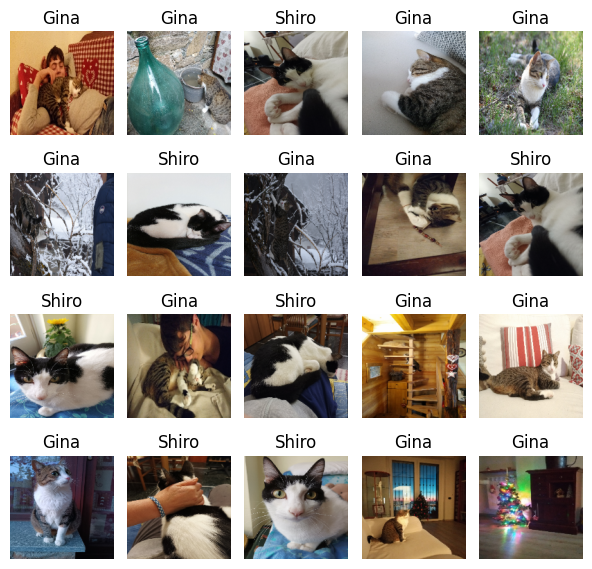

In [125]:
if False:
    n_rows = 4 # columns of the subplpots
    n_cols = 5 # rows of the subplots
    plt.figure(figsize=(6,6)) # size of images
    for i, (img,label) in enumerate(testing_dataset.take(n_rows*n_cols)):
      plt.subplot(n_rows,n_cols,i+1)
      plt.imshow(img/255) # normlalize images
      plt.axis('off') # remove axis
      plt.tight_layout(pad=1.0) # add padding between images
      plt.title('Gina' if not(label) else 'Shiro') # set lables
    plt.show()

In [142]:

tf.math.confusion_matrix(
    [label for img,label in testing_dataset],
    (model.predict(testing_dataset.batch(1))>0).astype(int)
)

255/255 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[100,  59],
       [ 64,  32]], dtype=int32)>

## Notes:
+ applying fine tuning ``` apply_fine_tuning = True``` drastically worsen accuracy (from 0.98 to 0.62)
+ increasig number of epochs from 4 to 7 ``` numer_of_epochs = 7``` does not change much the result
+ using the optimizer ```keras.optimizers.Adam(0.00001)``` gives a worst result
+ using the optimizer ```keras.optimizers.Adam(0.001)``` gives a similar result to 'adam'
+ using the optimizer ```keras.optimizers.Adam(0.01)``` and ``` numer_of_epochs = 7``` causes overfitting




In [127]:
#ldat, vdat, tdat = tfds.load('cats_vs_dogs',
#                             split=['train[:40%]', 'train[40%:50%]', 'train[50%:60%]'],
#                             as_supervised=True)

In [128]:
#type(ldat)

In [129]:
#print('train: %d' %tf.data.experimental.cardinality(learning_dataset))
#print('valid: %d' %tf.data.experimental.cardinality(validation_dataset))
#print('test:  %d' %tf.data.experimental.cardinality(tdat))

In [130]:
#ldat.take(9)

In [131]:
#imm_size = (150,150)
#ldat = ldat.map(lambda x,y: (tf.image.resize(x,imm_size),y))
#vdat = vdat.map(lambda x,y: (tf.image.resize(x,imm_size),y))
#tdat = tdat.map(lambda x,y: (tf.image.resize(x,imm_size),y))

In [132]:
#batch_size = 32
#ldat = ldat.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
#vdat = vdat.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
#tdat = tdat.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [133]:
#pretrained_model = keras.applications.Xception(
#    weights='imagenet',
#    input_shape=(150,150,3),
#    include_top=False
#)

In [134]:
#pretrained_model.trainable = False

In [135]:
#input = keras.Input(shape=(150,150,3))
#x = data_augmentation(input)
#x = keras.layers.Rescaling(scale=1./(255/2),offset=-1)(x)
#x = pretrained_model(x)
#x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.2)(x)
#output = keras.layers.Dense(1)(x)
#model = keras.Model(inputs = input,outputs = output)
#model.summary()

In [136]:
#model.compile(
#    optimizer = 'adam',
#    loss      = keras.losses.BinaryCrossentropy(from_logits=True),
#    metrics   = [keras.metrics.BinaryAccuracy()]
#)

In [137]:
#model.fit(
#    ldat,
#    epochs=4,
#    validation_data=vdat
#)

In [138]:
#pretrained_model.trainable = True
#model.summary()

In [139]:
#model.compile(
#    optimizer = keras.optimizers.Adam(0.00001),
#    loss      = keras.losses.BinaryCrossentropy(from_logits=True),
#    metrics   = [keras.metrics.BinaryAccuracy()]
#)

In [140]:
#model.fit(
#    learning_dataset,
#    epochs=4,
#    validation_data=validation_dataset
#)

In [141]:
print ("accuracy:" + str(0)+str('.')+"9"*int(str(33)'3'))

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-141-13d6c6550a4b>, line 1)